#A history of crime by Simon in San Francisco Crime Classification 
### https://www.kaggle.com/swbevan/sf-crime/a-history-of-crime-python
### 7월 캐글뽀개기 파이썬 시각화 예제 

In [18]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import pandas as pd
import scipy
import zipfile
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [3]:
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

In [4]:
train = pd.read_csv('train.csv')

In [5]:
cats = list(set(train.Category))
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")

In [6]:
dates = []
datesAll = np.array([datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in train.Dates])

In [8]:
datesAll

array([datetime.datetime(2015, 5, 13, 23, 53),
       datetime.datetime(2015, 5, 13, 23, 53),
       datetime.datetime(2015, 5, 13, 23, 33), ...,
       datetime.datetime(2003, 1, 6, 0, 1),
       datetime.datetime(2003, 1, 6, 0, 1),
       datetime.datetime(2003, 1, 6, 0, 1)], dtype=object)

In [9]:
startDate = (np.min(datesAll)).date()
endDate = (np.max(datesAll)).date()
alldates = pd.bdate_range(startDate, endDate, freq="m")
dayDF = pd.DataFrame(np.NAN, index=alldates, columns=['x'])
subCats = ['KIDNAPPING','PROSTITUTION','VEHICLE THEFT','LOITERING','SUICIDE','FORGERY/COUNTERFEITING','DRUNKENNESS','DRUG/NARCOTIC','LARCENY/THEFT']   

In [10]:
alldates

DatetimeIndex(['2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31',
               '2003-09-30', '2003-10-31', 
               ...
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30'],
              dtype='datetime64[ns]', length=148, freq='M', tz=None)

In [12]:
pLoop = 1

In [14]:
cats

['KIDNAPPING',
 'WEAPON LAWS',
 'SECONDARY CODES',
 'WARRANTS',
 'PROSTITUTION',
 'EMBEZZLEMENT',
 'LOITERING',
 'SUICIDE',
 'DRIVING UNDER THE INFLUENCE',
 'SEX OFFENSES FORCIBLE',
 'ROBBERY',
 'BURGLARY',
 'SUSPICIOUS OCC',
 'FAMILY OFFENSES',
 'BRIBERY',
 'FORGERY/COUNTERFEITING',
 'BAD CHECKS',
 'DRUNKENNESS',
 'GAMBLING',
 'OTHER OFFENSES',
 'RECOVERED VEHICLE',
 'FRAUD',
 'ARSON',
 'DRUG/NARCOTIC',
 'TRESPASS',
 'LARCENY/THEFT',
 'VANDALISM',
 'NON-CRIMINAL',
 'EXTORTION',
 'PORNOGRAPHY/OBSCENE MAT',
 'LIQUOR LAWS',
 'SEX OFFENSES NON FORCIBLE',
 'TREA',
 'VEHICLE THEFT',
 'STOLEN PROPERTY',
 'ASSAULT',
 'MISSING PERSON',
 'DISORDERLY CONDUCT',
 'RUNAWAY']

In [15]:
for cat in cats:
        saveFile = cat+'.png'
        print(saveFile)
        #just subset for display purposes
        if cat in subCats:
            try:
                fig = plt.figure(figsize = (11.69, 8.27))
                plt.title(cat)
                
                #plot image
                ax = plt.subplot(2,2,1)
                ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)
    
                lineNum = 0
                crime  = cat
                Xcoord = (train[train.Category==cat].X).values
                Ycoord = (train[train.Category==cat].Y).values
                dates = datesAll[np.where(train.Category==cat)]
                Z = np.ones([len(Xcoord),1])
                
                    
                #create dataframe
                df = pd.DataFrame([ [ Z[row][0],Xcoord[row],Ycoord[row]  ] for row in range(len(Z))],
                       index=[dates[row] for row in range(len(dates))],
                       columns=['z','xcoord','ycoord']) 
                 
                #resample to sum by month
                df2 = df.resample('m', how='sum')
                
                #create uniform time series
                allTimes = dayDF \
                .join(df2) \
                .drop('x', axis=1) \
                .fillna(0)
            
                movAv = pd.rolling_mean(allTimes['z'],window=12,min_periods=1)
            
                #kde plot by year
                kdeMaxX = []
                kdeMaxY = []
                for yLoop in range(2003,2015):
                    allData2 = df[(df.index.year == yLoop)]
                   
                    kde = scipy.stats.gaussian_kde(np.array(allData2['xcoord']))
                    density = kde(np.array(allData2['xcoord']))
                    kde2 = scipy.stats.gaussian_kde(np.array(allData2['ycoord']))
                    density2 = kde2(np.array(allData2['ycoord']))
                    kdeMaxX.append((allData2['xcoord'][density==np.max(density)]).values[0])
                    kdeMaxY.append((allData2['ycoord'][density2==np.max(density2)]).values[0])
                    
                
                #create a quiver plot to show movement of centre of KDE per year
                kdeOut = sns.kdeplot(np.array(allData2['xcoord']), np.array(allData2['ycoord']),shade=True, cut=10, clip=clipsize,alpha=0.5)
                kdeMaxX = np.array(kdeMaxX)
                kdeMaxY = np.array(kdeMaxY)
                plt.quiver(kdeMaxX[:-1], kdeMaxY[:-1], kdeMaxX[1:]-kdeMaxX[:-1], kdeMaxY[1:]-kdeMaxY[:-1], scale_units='xy', angles='xy', scale=1,color='r')
    
                #time series plot with 12 month moving average
                ax = plt.subplot(2,1,2)
                plt.plot(allTimes.index,allTimes['z'])
                plt.plot(allTimes.index,movAv,'r')
                
                #heatmap to look how data varies by day of week
                ax = plt.subplot(2,2,2)
                heatData = []
                yLoopCount=0
                yearName = []
                weekName = ['mon','tue','wed','thu','fri','sat','sun']
                yearName = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014']
                for yLoop in range(2003,2015):
                    heatData.append([])
                    for dLoop in range(7):
                        allData2 = df[(df.index.year == yLoop) & (df.index.weekday == dLoop)]
                        heatData[yLoopCount].append(sum(allData2['z'].values))
                    yLoopCount+=1
                
                #normlise
                heatData = np.array(heatData)/np.max(np.array(heatData))
                sns.heatmap(heatData, annot=True,xticklabels=weekName,yticklabels=yearName);
                
                plt.title(cat)
                plt.savefig(saveFile)
                #pdf_pages.savefig(fig)
            
            except:
                print("error: " + cat)
            
        pLoop+=1

KIDNAPPING.png
WEAPON LAWS.png
SECONDARY CODES.png
WARRANTS.png
PROSTITUTION.png
EMBEZZLEMENT.png
LOITERING.png
SUICIDE.png
DRIVING UNDER THE INFLUENCE.png
SEX OFFENSES FORCIBLE.png
ROBBERY.png
BURGLARY.png
SUSPICIOUS OCC.png
FAMILY OFFENSES.png
BRIBERY.png
FORGERY/COUNTERFEITING.png
error: FORGERY/COUNTERFEITING
BAD CHECKS.png
DRUNKENNESS.png
GAMBLING.png
OTHER OFFENSES.png
RECOVERED VEHICLE.png
FRAUD.png
ARSON.png
DRUG/NARCOTIC.png
error: DRUG/NARCOTIC
TRESPASS.png
LARCENY/THEFT.png
error: LARCENY/THEFT
VANDALISM.png
NON-CRIMINAL.png
EXTORTION.png
PORNOGRAPHY/OBSCENE MAT.png
LIQUOR LAWS.png
SEX OFFENSES NON FORCIBLE.png
TREA.png
VEHICLE THEFT.png
STOLEN PROPERTY.png
ASSAULT.png
MISSING PERSON.png
DISORDERLY CONDUCT.png
RUNAWAY.png


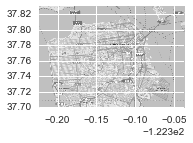

In [19]:
ax = plt.subplot(2,2,1)
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box)

In [20]:
lineNum = 0
Xcoord = (train[train.Category==cats[1]].X).values
Ycoord = (train[train.Category==cats[1]].Y).values
dates = datesAll[np.where(train.Category==cats[1])]
Z = np.ones([len(Xcoord),1])

In [25]:
df = pd.DataFrame([ [ Z[row][0],Xcoord[row],Ycoord[row]  ] for row in range(len(Z))],
                       index=[dates[row] for row in range(len(dates))],
                       columns=['z','xcoord','ycoord']) 

In [26]:
df

,z,xcoord,ycoord
2015-05-13 20:29:00,1,-122.473182,37.721565
2015-05-13 18:42:00,1,-122.421427,37.794603
2015-05-12 23:30:00,1,-122.397202,37.753535
2015-05-11 22:23:00,1,-122.405248,37.711723
2015-05-11 20:45:00,1,-122.419208,37.760234
2015-05-11 20:45:00,1,-122.419208,37.760234
2015-05-11 19:07:00,1,-122.386594,37.727818
2015-05-11 19:07:00,1,-122.386594,37.727818
2015-05-11 19:07:00,1,-122.386594,37.727818
2015-05-11 18:58:00,1,-122.440462,37.718027


In [27]:
df2 = df.resample('m', how='sum')

In [28]:
df2

,z,xcoord,ycoord
2003-01-31,49,-5998.746013,1850.127966
2003-02-28,53,-6488.111587,2001.301356
2003-03-31,56,-6855.943643,2114.169846
2003-04-30,55,-6733.508267,2076.737272
2003-05-31,55,-6733.094850,2076.691216
2003-06-30,39,-4774.376713,1472.261416
2003-07-31,31,-3795.148967,1170.414600
2003-08-31,44,-5386.442811,1661.414577
2003-09-30,58,-7100.499257,2189.902609
2003-10-31,69,-8447.329393,2605.539767


In [29]:
allTimes = dayDF \
                .join(df2) \
                .drop('x', axis=1) \
                .fillna(0)

In [30]:
allTimes

,z,xcoord,ycoord
2003-01-31,49,-5998.746013,1850.127966
2003-02-28,53,-6488.111587,2001.301356
2003-03-31,56,-6855.943643,2114.169846
2003-04-30,55,-6733.508267,2076.737272
2003-05-31,55,-6733.094850,2076.691216
2003-06-30,39,-4774.376713,1472.261416
2003-07-31,31,-3795.148967,1170.414600
2003-08-31,44,-5386.442811,1661.414577
2003-09-30,58,-7100.499257,2189.902609
2003-10-31,69,-8447.329393,2605.539767


In [36]:
movAv = pd.rolling_mean(allTimes['z'],window=12,min_periods=1)

In [37]:
movAv

2003-01-31    49.000000
2003-02-28    51.000000
2003-03-31    52.666667
2003-04-30    53.250000
2003-05-31    53.600000
2003-06-30    51.166667
2003-07-31    48.285714
2003-08-31    47.750000
2003-09-30    48.888889
2003-10-31    50.900000
2003-11-30    51.545455
2003-12-31    50.416667
2004-01-31    49.666667
2004-02-29    50.583333
2004-03-31    51.666667
2004-04-30    53.083333
2004-05-31    53.250000
2004-06-30    53.500000
2004-07-31    54.500000
2004-08-31    54.416667
2004-09-30    54.166667
2004-10-31    53.416667
2004-11-30    52.250000
2004-12-31    52.833333
2005-01-31    54.000000
2005-02-28    52.583333
2005-03-31    51.000000
2005-04-30    49.500000
2005-05-31    48.833333
2005-06-30    50.250000
                ...    
2012-11-30    63.250000
2012-12-31    63.333333
2013-01-31    62.583333
2013-02-28    61.000000
2013-03-31    61.833333
2013-04-30    62.750000
2013-05-31    61.500000
2013-06-30    63.666667
2013-07-31    63.750000
2013-08-31    65.000000
2013-09-30    63

In [42]:
kdeMaxX = []
kdeMaxY = []
for yLoop in range(2003,2015):
    allData2 = df[(df.index.year == yLoop)]
    kde = scipy.stats.gaussian_kde(np.array(allData2['xcoord']))
    density = kde(np.array(allData2['xcoord']))
    kde2 = scipy.stats.gaussian_kde(np.array(allData2['ycoord']))
    density2 = kde2(np.array(allData2['ycoord']))
    kdeMaxX.append((allData2['xcoord'][density==np.max(density)]).values[0])
    kdeMaxY.append((allData2['ycoord'][density2==np.max(density2)]).values[0])

In [53]:
kdeMaxY

array([ 37.78090397,  37.78077843,  37.7808866 ,  37.78139873,
        37.78079208,  37.78152627,  37.78186219,  37.78053454,
        37.78097067,  37.78149872,  37.78084932,  37.78105784])

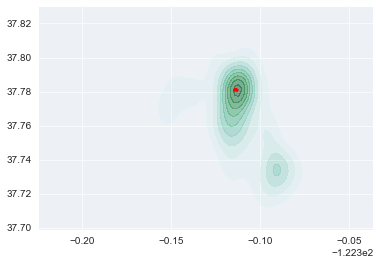

In [106]:
kdeOut = sns.kdeplot(np.array(allData2['xcoord']), np.array(allData2['ycoord']),shade=True, cut=10, clip=clipsize,alpha=0.5)
kdeMaxX = np.array(kdeMaxX)
kdeMaxY = np.array(kdeMaxY)
plt.quiver(kdeMaxX[:-1], kdeMaxY[:-1], kdeMaxX[1:]-kdeMaxX[:-1], kdeMaxY[1:]-kdeMaxY[:-1], scale_units='xy', angles='xy', scale=1,color='r')  

In [88]:
kdeMaxX[:-1]

array([-122.41407067, -122.41474384, -122.41367938, -122.41461526,
       -122.41363125, -122.41363125, -122.414089  , -122.41323759,
       -122.41289925, -122.41356409, -122.41431786])

In [84]:
kdeMaxY[:-1]

array([ 37.78090397,  37.78077843,  37.7808866 ,  37.78139873,
        37.78079208,  37.78152627,  37.78186219,  37.78053454,
        37.78097067,  37.78149872,  37.78084932])

In [89]:
kdeMaxX[1:]-kdeMaxX[:-1]

array([-0.00067317,  0.00106446, -0.00093589,  0.00098401,  0.        ,
       -0.00045775,  0.00085141,  0.00033834, -0.00066484, -0.00075377,
        0.00017288])

In [90]:
kdeMaxY[1:]-kdeMaxY[:-1]

array([-0.00012554,  0.00010818,  0.00051213, -0.00060665,  0.00073419,
        0.00033592, -0.00132765,  0.00043613,  0.00052805, -0.0006494 ,
        0.00020851])

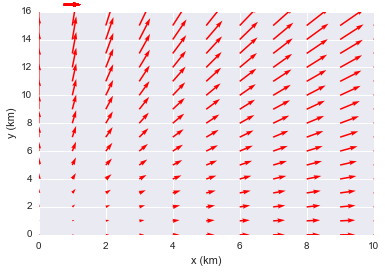

In [103]:
x = np.linspace(0,10,11)
y = np.linspace(0,15,16)
(X,Y) = np.meshgrid(x,y)
u = 5*X
v = 5*Y
q = plt.quiver(X,Y,u,v,angles='xy',scale=1000,color='r')
p = plt.quiverkey(q,1,16.5,50,"50 m/s",coordinates='data',color='r')
xl = plt.xlabel("x (km)")
yl = plt.ylabel("y (km)")
plt.show()

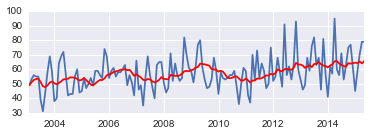

In [76]:
ax = plt.subplot(2,1,2)
plt.plot(allTimes.index,allTimes['z'])
plt.plot(allTimes.index,movAv,'r')

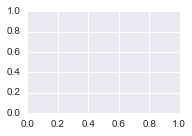

In [77]:
ax = plt.subplot(2,2,2)
heatData = []
yLoopCount=0
yearName = []
weekName = ['mon','tue','wed','thu','fri','sat','sun']
yearName = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014']
for yLoop in range(2003,2015):
    heatData.append([])
    for dLoop in range(7):
        allData2 = df[(df.index.year == yLoop) & (df.index.weekday == dLoop)]
        heatData[yLoopCount].append(sum(allData2['z'].values))
    yLoopCount+=1

In [78]:
heatData

[[98.0, 89.0, 86.0, 79.0, 99.0, 88.0, 66.0],
 [68.0, 88.0, 112.0, 89.0, 124.0, 66.0, 87.0],
 [99.0, 103.0, 90.0, 110.0, 98.0, 100.0, 79.0],
 [90.0, 97.0, 95.0, 107.0, 100.0, 101.0, 88.0],
 [89.0, 96.0, 76.0, 95.0, 95.0, 101.0, 89.0],
 [118.0, 114.0, 97.0, 80.0, 110.0, 96.0, 97.0],
 [93.0, 86.0, 101.0, 124.0, 102.0, 110.0, 85.0],
 [95.0, 95.0, 111.0, 94.0, 96.0, 85.0, 68.0],
 [90.0, 91.0, 106.0, 107.0, 97.0, 100.0, 85.0],
 [98.0, 90.0, 125.0, 132.0, 105.0, 102.0, 108.0],
 [86.0, 93.0, 107.0, 110.0, 120.0, 125.0, 95.0],
 [108.0, 97.0, 106.0, 112.0, 117.0, 113.0, 122.0]]

In [80]:
heatData = np.array(heatData)/np.max(np.array(heatData))

In [82]:
heatData

array([[ 0.74242424,  0.67424242,  0.65151515,  0.59848485,  0.75      ,
         0.66666667,  0.5       ],
       [ 0.51515152,  0.66666667,  0.84848485,  0.67424242,  0.93939394,
         0.5       ,  0.65909091],
       [ 0.75      ,  0.78030303,  0.68181818,  0.83333333,  0.74242424,
         0.75757576,  0.59848485],
       [ 0.68181818,  0.73484848,  0.71969697,  0.81060606,  0.75757576,
         0.76515152,  0.66666667],
       [ 0.67424242,  0.72727273,  0.57575758,  0.71969697,  0.71969697,
         0.76515152,  0.67424242],
       [ 0.89393939,  0.86363636,  0.73484848,  0.60606061,  0.83333333,
         0.72727273,  0.73484848],
       [ 0.70454545,  0.65151515,  0.76515152,  0.93939394,  0.77272727,
         0.83333333,  0.64393939],
       [ 0.71969697,  0.71969697,  0.84090909,  0.71212121,  0.72727273,
         0.64393939,  0.51515152],
       [ 0.68181818,  0.68939394,  0.8030303 ,  0.81060606,  0.73484848,
         0.75757576,  0.64393939],
       [ 0.74242424,  0.6818

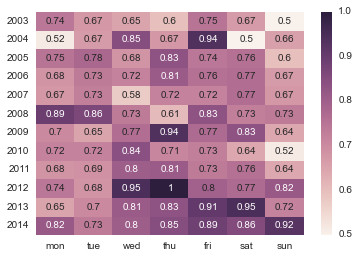

In [93]:
heatData = np.array(heatData)/np.max(np.array(heatData))
sns.heatmap(heatData, annot=True,xticklabels=weekName,yticklabels=yearName);